In [1]:
import os
os.environ["PATH"] = os.path.expanduser("~/texlive/bin/x86_64-linux") + ":" + os.environ["PATH"]

import sys
sys.path.insert(0, "/Users/rstiskalek/Projects/candel")

from os.path import join
import numpy as np
from h5py import File
import matplotlib.pyplot as plt
import candel

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [21]:
mock_dir = "/Users/rstiskalek/Projects/CANDEL/data/CF4_mock/"
CF4 = candel.pvdata.load_CF4_data("/Users/rstiskalek/Projects/CANDEL/data/CF4", which_band="w1",)

2025-09-14 00:33:35 initially loaded 9788 galaxies from CF4 TFR data.
2025-09-14 00:33:35 removed 6537 galaxies, thus 3251 remain.


In [22]:
field_loader = candel.field.name2field_loader("Carrick2015")(
    path_density="/Users/rstiskalek/Projects/CANDEL/data/fields/carrick2015_twompp_density.npy",
    path_velocity="/Users/rstiskalek/Projects/CANDEL/data/fields/carrick2015_twompp_velocity.npy"
    )

kwargs = {
    'r_grid': np.linspace(0.1, 250, 251),
    'Vext_mag': 0.,
    'Vext_ell': 302,
    'Vext_b': -17,
    'sigma_v': 280,
    'a_TFR': -19.95,
    'b_TFR': -9.6,
    'c_TFR': 10.5,
    'sigma_int': 0.34,
    'zeropoint_dipole_mag': 0.087,
    # 'zeropoint_dipole_mag': None,
    'zeropoint_dipole_ell': 127.0,
    'zeropoint_dipole_b': 10.0,
    'beta': 0.0,
    'h': 1,
    'eta_prior_mean': 0.08,
    'eta_prior_std': 0.13,
    'e_eta': 0.023,
    'e_mag': 0.05,
    'b_min': 7.5,
    'zcmb_max': 0.05,
    'R': 32,
    'n': 1.4,
    'p': 1.8,
    'r2distmod': candel.Distance2Distmod(),
    'r2z': candel.Distance2Redshift(),
    'field_loader': field_loader,
}


### Single mock

In [23]:
nsamples = 300
mock = candel.mock.gen_TFR_mock(nsamples, seed=30, **kwargs)

2025-09-14 00:33:37 Rejecting 1 samples with zcmb > 0.05


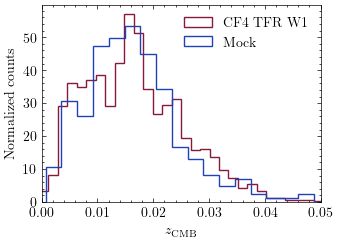

In [24]:
import scienceplots
COLS = ["#87193d", "#1e42b9", "#d42a29", "#05dd6b", "#ee35d5"]

with plt.style.context("science"):
    plt.figure()
    plt.hist(CF4["zcmb"], bins="auto", density=1, histtype="step", label="CF4 TFR W1", color=COLS[0])
    plt.hist(mock["zcmb"], bins="auto", density=1, histtype="step", label="Mock", color=COLS[1])

    plt.xlabel(r"$z_{\rm CMB}$")
    plt.ylabel("Normalized counts")
    plt.legend()

    plt.tight_layout()
    plt.xlim(0, 0.05)
    plt.savefig("/Users/rstiskalek/Downloads/mock_redshift.pdf", bbox_inches="tight", dpi=450)
    plt.show()

In [25]:
# print(f"writing `{fname}`.")
# with File(fname, 'w') as f:
#     grp = f.create_group("mock")
#     for key, value in mock.items():
#         grp.create_dataset(key, data=value, dtype=np.float32)

#     for key, value in kwargs.items():
#         if isinstance(value, (float, int, bool)):
#             grp.attrs[key] = value


### Many mocks to test detecting the dipole

In [27]:
# nsample_list = [500, 1000, 2000, 4000, 8000, 16000, 32000]
# nseeds_per_nsample = 10
nsample_list = [750, ]
nseeds_per_nsample = 2

index = 0
records = []

for nsamples in nsample_list:
    for i in range(nseeds_per_nsample):
        seed = 1000 * nsamples + i  # unique, reproducible
        fname = join(mock_dir, f"mock_{index}.hdf5")
        print(f"preparing`{fname}`.")

        mock = candel.mock.gen_TFR_mock(
            nsamples, seed=seed, **kwargs, verbose=False)

        with File(fname, 'w') as f:
            grp = f.create_group("mock")
            for key, value in mock.items():
                grp.create_dataset(key, data=value, dtype=np.float32)

            for key, value in kwargs.items():
                if isinstance(value, (float, int, bool)):
                    grp.attrs[key] = value
            grp.attrs["seed"] = seed
            grp.attrs["nsamples"] = nsamples

        records.append((index, nsamples))
        index += 1

# Save index tracking table
records = np.array(records, dtype=int)
header = "index nsamples"
np.savetxt(join(mock_dir, "mock_index.txt"), records, fmt="%d", header=header)

preparing`/Users/rstiskalek/Projects/CANDEL/data/CF4_mock/mock_0.hdf5`.
preparing`/Users/rstiskalek/Projects/CANDEL/data/CF4_mock/mock_1.hdf5`.
